In [1071]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import cv2
import time
import os

In [878]:
class Vehicle:
    def __init__(self, current_x, current_v, current_s,vehicle_length, delta_t, lane_length, global_clock):
        self.current_x = current_x
        self.current_v = current_v
        self.current_a = 0
        self.current_s = 2000  # Initially set to a large value
        self.delta_t = delta_t
        self.vehicle_length = vehicle_length
        self.lane_length = lane_length

        self.history_t = [global_clock]
        self.history_x = [current_x]
        self.history_v = [current_v]
        self.history_a = [0]
        self.history_s = [current_s]
        self.history_delta_v = []

        # IDM parameters
        self.v0 = 25  # Desired velocity
        self.T = 1.5    # Safe time headway
        self.a = 0.3    # Maximum acceleration
        self.b = 3    # Comfortable deceleration
        self.delta = 4  # Acceleration exponent
        self.s0 = 2     # Minimum gap
        self.red_visual_distance = np.random.normal(100, 2)  # Distance at which vehicle will stop for red light
        self.stopped_at_red = False
        self.stop_for_red = True

    def update(self, lead_vehicle, is_red_light, global_clock):

        # Update s (distance to leading vehicle or traffic light)
        if lead_vehicle:
            self.current_s = lead_vehicle.current_x - self.current_x - lead_vehicle.vehicle_length
        elif is_red_light and self.stop_for_red:
            self.current_s = max(0, self.lane_length - self.current_x)
        else:
            self.current_s = 2000  # Large value for free driving

        # Calculate acceleration using IDM
        lead_v = lead_vehicle.current_v if lead_vehicle else self.v0
        if is_red_light and self.stop_for_red and self.current_s < self.red_visual_distance :  # Close to red light
            lead_v = 0
        delta_v = self.current_v - lead_v
        s_star = (self.s0 + max(0, self.current_v * self.T + 
                  (self.current_v * delta_v) / 
                  (2 * np.sqrt(self.a * self.b))))
        
        self.current_a = self.a * (1 - (self.current_v / self.v0)**self.delta - (s_star / max(self.current_s, 0.01))**2)
        if self.current_a < -8:
            self.current_a = -8
        if self.current_a > 3:
            self.current_a = 3
        # Update velocity and position
        self.current_v = max(0, self.current_v + self.current_a * self.delta_t)
        self.current_x = min(self.lane_length, self.current_x + self.current_v * self.delta_t)

        # Save to history
        self.history_t.append(global_clock)
        self.history_x.append(self.current_x)
        self.history_v.append(self.current_v)
        self.history_a.append(self.current_a)
        self.history_s.append(self.current_s)
        self.history_delta_v.append(delta_v)

In [905]:
np.random.exponential(mean_headway)

105.98669196566433

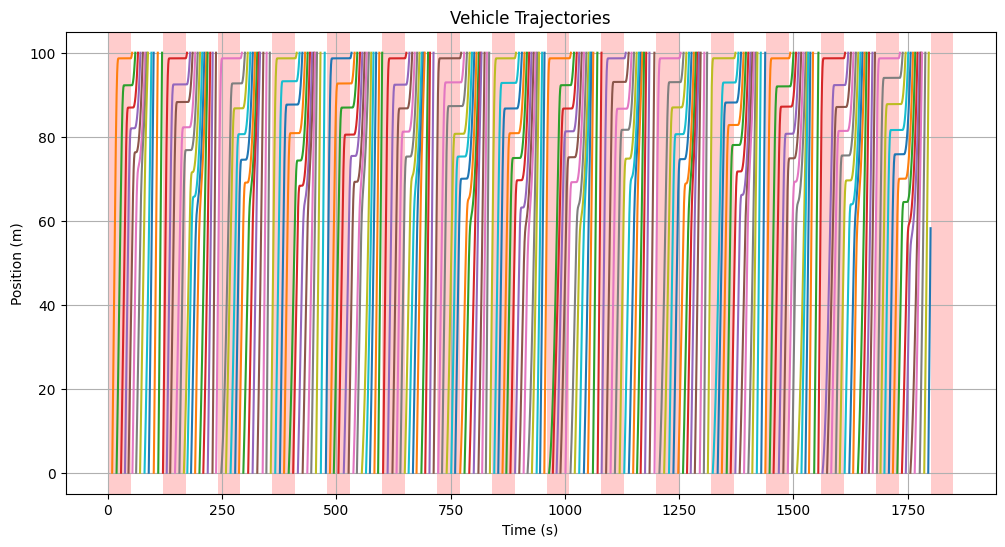

In [992]:

def run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway):
    # Initialize variables
    mean_vehicle_length = 4.5
    mean_speed = 10

    vehicles = []
    exited_vehicles = []
    global_clock = 0
    next_vehicle_time = np.random.normal(mean_headway, 1)

    # Simulation loop
    while global_clock < simulation_time:
        light_cycle = red_light_time + green_light_time
        is_red_light = (global_clock % light_cycle) < red_light_time

        # Generate new vehicle if it's time
        if global_clock >= next_vehicle_time:
            vehicle_length = np.random.normal(mean_vehicle_length, 0.5)
            
            if vehicles:
                # Consider the tail car's speed and position
                tail_car = vehicles[-1]
                current_v = np.random.normal(tail_car.current_v, 1)
                # Position the new car behind the tail car, allowing negative positions
                if tail_car.current_x - tail_car.vehicle_length < 0:
                    current_x = tail_car.current_x - tail_car.vehicle_length - tail_car.s0 - 0.2 * vehicle_length
                    current_s = tail_car.s0 + 0.2 * vehicle_length
                else:
                    current_x = 0
                    current_s = tail_car.current_x - tail_car.vehicle_length
            else:
                current_v = np.random.normal(mean_speed, 1)
                current_x = 0
                current_s = 10000
                
            new_vehicle = Vehicle(current_x, current_v, current_s,vehicle_length, delta_t, lane_length, global_clock)
            vehicles.append(new_vehicle)
            next_vehicle_time = global_clock + np.random.normal(mean_headway, 1)
        global_clock += delta_t
        # Update vehicles and check for exits
        i = 0
        while i < len(vehicles):
            vehicle = vehicles[i]
            lead_vehicle = vehicles[i-1] if i > 0 else None
            vehicle.update(lead_vehicle, is_red_light, global_clock)
            
            # Check if vehicle has exited the lane
            if vehicle.current_x >= lane_length:
                exited_vehicles.append(vehicles.pop(i))
            else:
                i += 1

       

    return vehicles, exited_vehicles

# Run simulation
lane_length = 100  # meters
red_light_time = 50  # seconds
green_light_time = 70  # seconds
simulation_time = 1800  # seconds
delta_t = 0.1  # seconds
mean_headway = 9.5 # seconds

vehicles, exited_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway)

# Plotting
plt.figure(figsize=(12, 6))
for vehicle in vehicles + exited_vehicles:
    plt.plot(vehicle.history_t, vehicle.history_x)

plt.title('Vehicle Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True)

# Add traffic light cycle visualization
for i in range(int(simulation_time / (red_light_time + green_light_time)) + 1):
    plt.axvspan(i * (red_light_time + green_light_time), (i * (red_light_time + green_light_time)) + red_light_time, 
                facecolor='red', alpha=0.2)

plt.show()

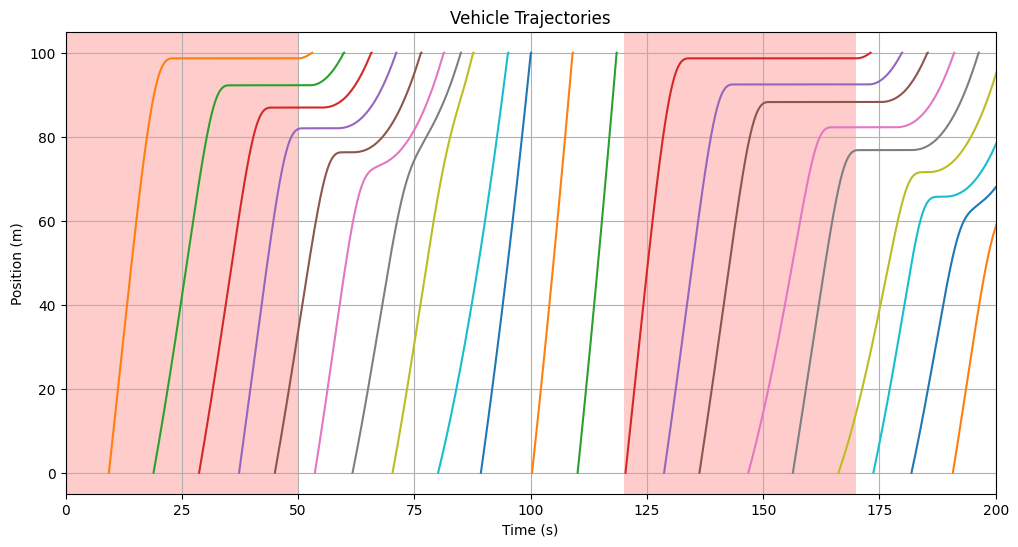

In [993]:
# Plotting
plt.figure(figsize=(12, 6))
for vehicle in vehicles + exited_vehicles:
    plt.plot(vehicle.history_t, vehicle.history_x)

plt.title('Vehicle Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True)

# Add traffic light cycle visualization
for i in range(int(simulation_time / (red_light_time + green_light_time)) + 1):
    plt.axvspan(i * (red_light_time + green_light_time), (i * (red_light_time + green_light_time)) + red_light_time, 
                facecolor='red', alpha=0.2)
plt.xlim(0, 200)
plt.show()

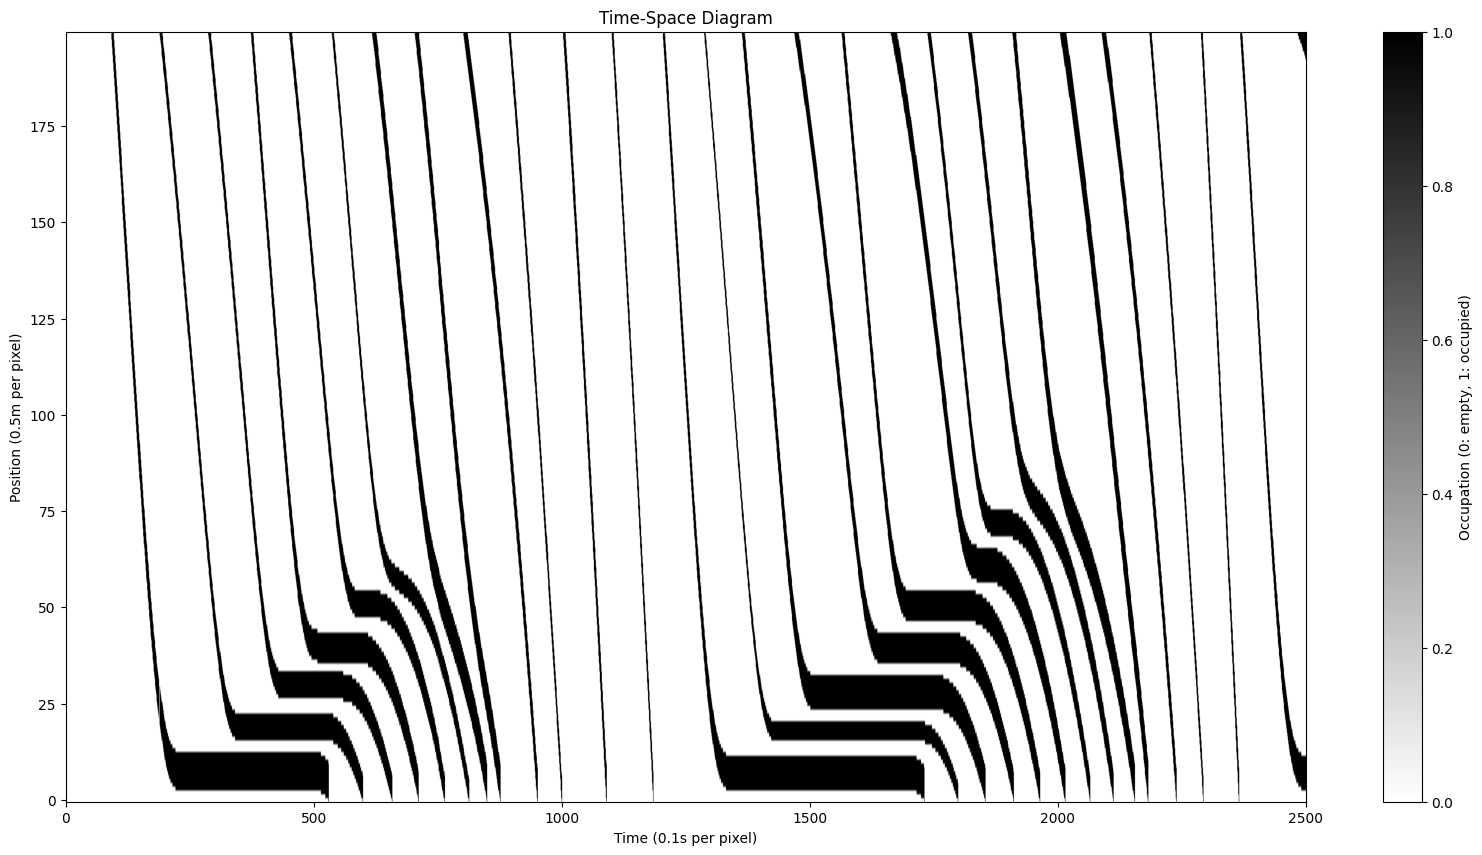

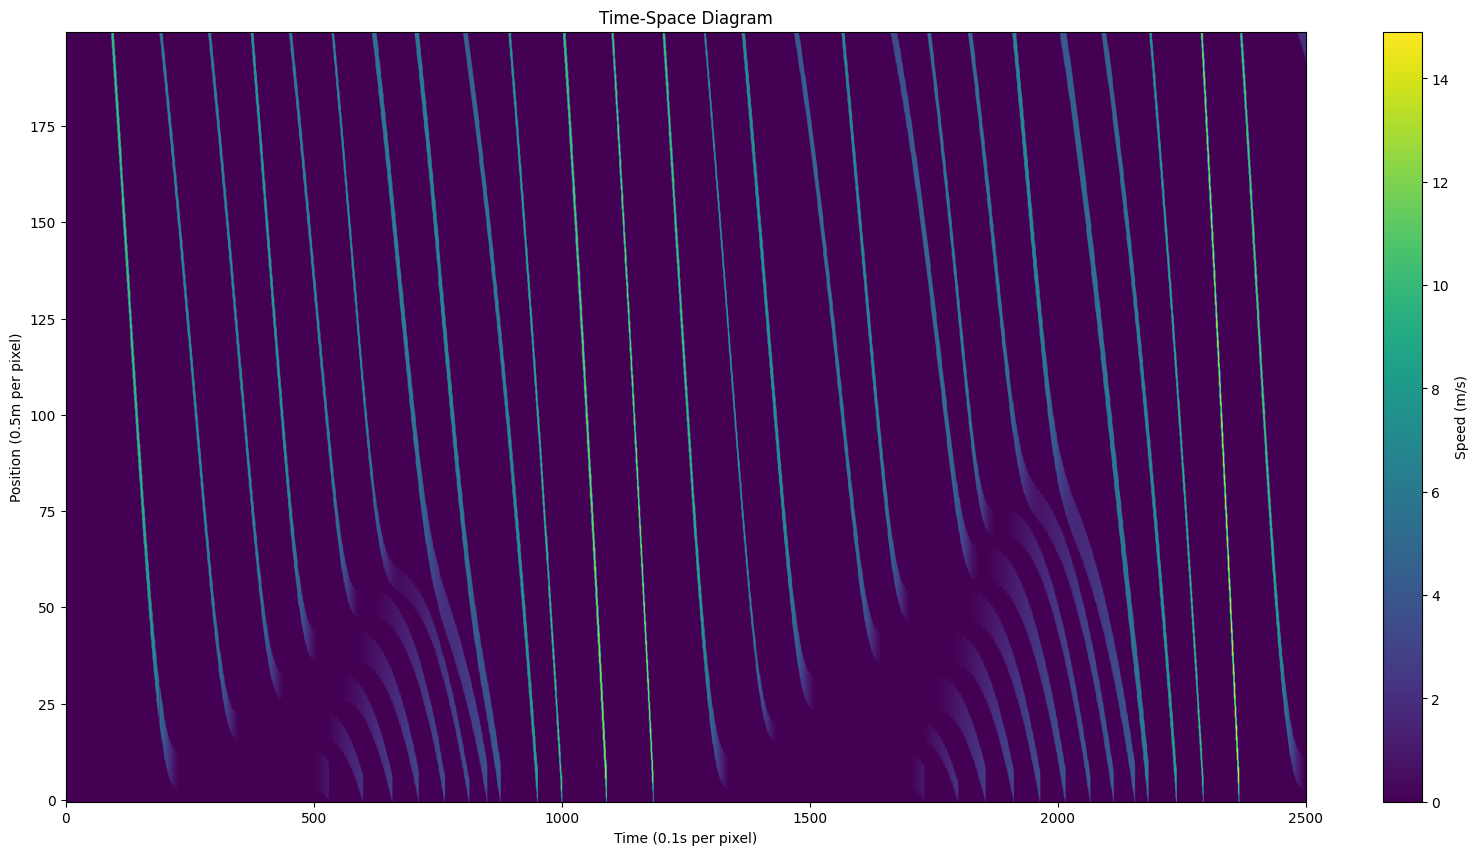

In [1001]:
def create_time_space_diagram(vehicles, lane_length, simulation_time, delta_t):
    # Set up the grid
    time_resolution = 0.1  # seconds per pixel
    space_resolution = 0.5  # meters per pixel
    time_pixels = int(simulation_time / time_resolution)
    space_pixels = int(lane_length / space_resolution)
    
    # Create an empty grid
    time_space_mask = np.zeros((space_pixels, time_pixels), dtype=int)
    speed_mask = np.zeros((space_pixels, time_pixels), dtype=float) 
    for vehicle in vehicles:
        vehicle_length_pixels = int(vehicle.vehicle_length / space_resolution)
        for t, x, v in zip(vehicle.history_t, vehicle.history_x, vehicle.history_v):
            time_idx = int(t / time_resolution) - 1
            space_idx = int(x / space_resolution) - 1
            # Mark the space occupied by the vehicle
            for i in range(vehicle_length_pixels):
                if 0 <= space_idx - i < space_pixels:
                    time_space_mask[space_idx - i, time_idx] = 1
                    speed_mask[space_idx - i, time_idx] = v
                
    return time_space_mask,speed_mask

# After running the simulation
time_space_mask,speed_mask = create_time_space_diagram(vehicles + exited_vehicles, lane_length, simulation_time, delta_t)
# upside down the grid
time_space_mask = np.flipud(time_space_mask)
speed_mask = np.flipud(speed_mask)
plt.figure(figsize=(20, 10))
plt.imshow(time_space_mask, cmap='binary', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')

plt.colorbar(label='Occupation (0: empty, 1: occupied)')
plt.xlim(0, 2500)
plt.show()

# plot speed of each pixel accoridng to the speed mask
plt.figure(figsize=(20, 10))
plt.imshow(speed_mask, cmap='viridis', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')
plt.colorbar(label='Speed (m/s)')
plt.xlim(0, 2500)
plt.show()



In [1072]:
# Randomly add some regular patches with angles to block the time_space_mask to simulate the occlusion events
def add_occlusions(binary_mask, num_occlusions=5):
    # Convert binary mask to uint8 type (required for OpenCV operations)
    occluded_mask = (binary_mask * 255).astype(np.uint8)
    num_occlusions = occluded_mask.shape[1] // 250
    height, width = occluded_mask.shape
    for _ in range(num_occlusions):
        # Random center point
        center = (np.random.randint(0, width), np.random.randint(0, height))
        
        # Random width and height (between 5% and 20% of image dimensions)
        rect_width = 20
        rect_height = 300
        
        # Random angle (0 to 180 degrees)
        angle = np.random.randint(0, 20)
        
        # Create rotated rectangle
        rect = ((center[0], center[1]), (rect_width, rect_height), angle)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        
        # Fill the rotated rectangle with white (255)
        cv2.fillPoly(occluded_mask, [box], 1)
    
    return occluded_mask



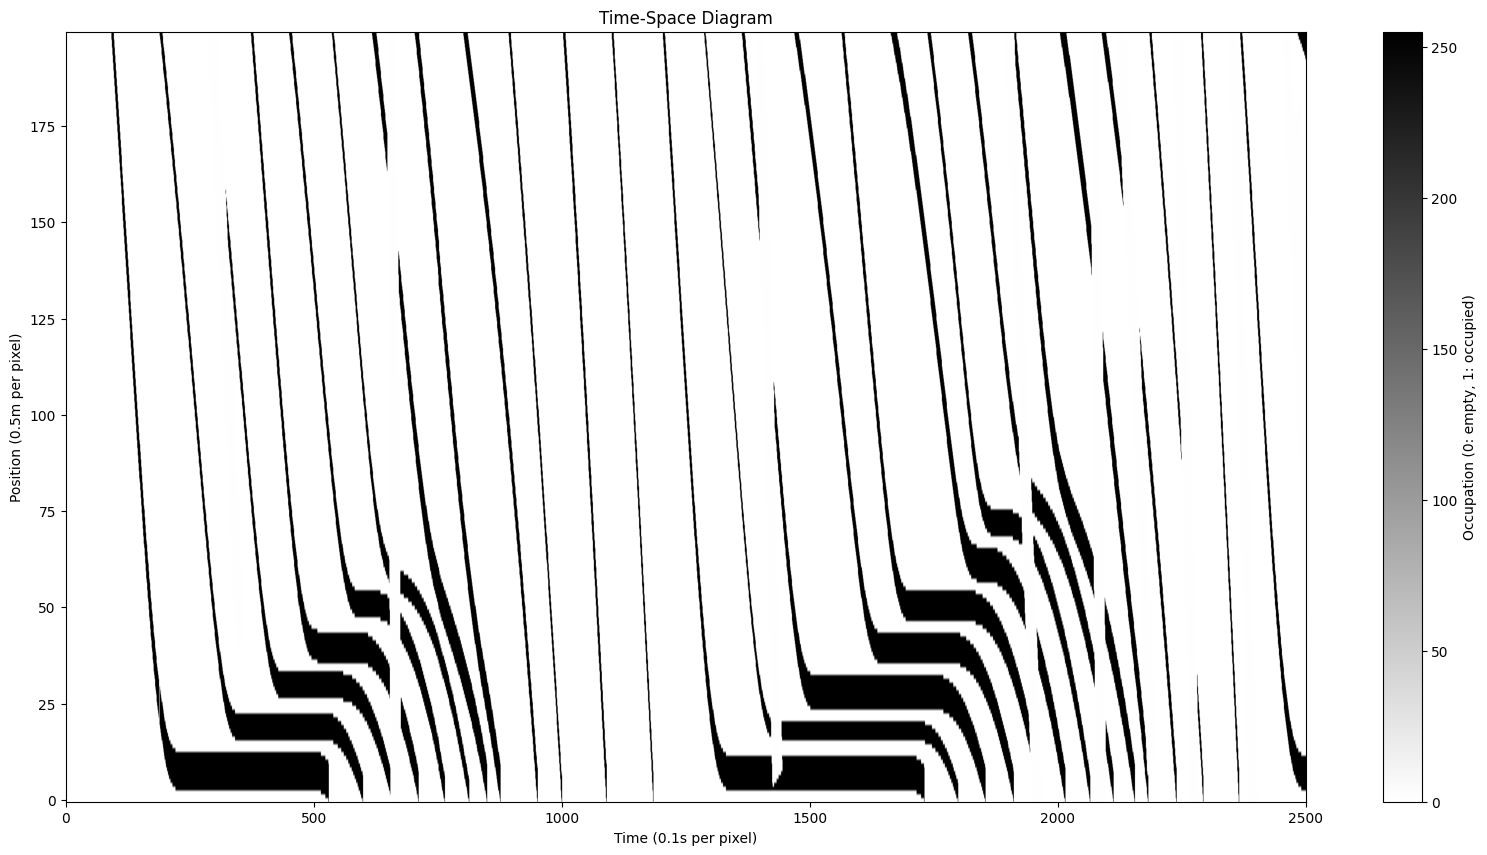

In [1070]:
# plot the occluded time_space_mask
plt.figure(figsize=(20, 10))
plt.imshow(mask, cmap='binary', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')
plt.colorbar(label='Occupation (0: empty, 1: occupied)')
plt.xlim(0, 2500)
plt.show()